In [244]:
import numpy as np
import torch

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

dataset = np.load("./data/splitted_cifar10_dataset.npz")

x_test, x_val, x_train, = torch.from_numpy(dataset['x_test']), torch.from_numpy(dataset['x_val']), torch.from_numpy(dataset['x_train'])
y_test, y_train, y_val = torch.from_numpy(dataset['y_test']), torch.from_numpy(dataset['y_train']), torch.from_numpy(dataset['y_val'])

import torch
from torchvision.transforms import v2

mean = torch.mean(x_train.type(torch.float32), dim=[0,1,2])
std = torch.std(x_train.type(torch.float32), dim=[0,1,2])

normalize = v2.Normalize(
        mean=mean,
        std=std,
    )

transforms = v2.Compose([
    v2.Resize((224,224)),
    v2.ToDtype(torch.float32),
    normalize,
])

from torch.utils.data import Dataset, DataLoader

class CIFAR10(Dataset):
    def __init__(self, image_tensors, image_labels, transform=None, target_transform=None):
        self.image_tensors = image_tensors
        self.image_labels = image_labels
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.image_labels)

    def __getitem__(self, idx):
        # Convert from HWC to CHW
        image = self.image_tensors[idx].permute(2, 1, 0)
        label = self.image_labels[idx].item()
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)

        return image, label

train_dataset = CIFAR10(x_train, y_train, transform=transforms)
val_dataset = CIFAR10(x_val, y_val, transform=transforms)
test_dataset = CIFAR10(x_test, y_test, transform=transforms)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
# val_loader = DataLoader(val_dataset, batch_size=64, shuffle=True)
# test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

# train_image, train_label = next(iter(train_loader))
# print(train_image.shape)
# print(train_image[0])
# print(train_label.shape)

cpu


In [2]:
def prepare(dataset, labels):
    # group dataset by labels
    labels = torch.unique(labels)
    grouped_indices = []

    for label in labels:
        indices = []
        for idx, (_, y) in enumerate(dataset):
            if y == label: 
                indices.append(idx)
        grouped_indices.append(indices)

    return grouped_indices

grouped_indices_train = prepare(train_dataset, y_train)
grouped_indices_val = prepare(val_dataset, y_val)
grouped_indices_test = prepare(test_dataset, y_test)
print("number of classes: ", len(grouped_indices_train))

/opt/homebrew/Caskroom/miniconda/base/envs/pytorch/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


number of classes:  10


In [69]:
import random
from itertools import combinations

from torch.utils.data import Dataset, DataLoader, Subset

def choose_classes(all_labels, ucc_range, generator="combination"):

    classes = torch.unique(all_labels).tolist()
    chosen = [] 
    combination_min = 1 # for random generator only
    combination_max = 100 # for random generator only
    
    if generator == "random":
       for ucc in range(ucc_range[0], ucc_range[1] + 1):
            num_combinations = random.randint(combination_min, combination_max)
            for _ in range(num_combinations):
                chosen.append(tuple(random.sample(classes, ucc))) 

    elif generator == "combination":
        for ucc in range(ucc_range[0], ucc_range[1] + 1):
            chosen.extend(combinations(classes, ucc))

    random.shuffle(chosen)

    return chosen

def choose_instances(grouped_indices, classes, bag_size = 100, generator="even"):

    instances = []

    if generator == "random":
        
        for current, class_index in enumerate(classes):
            # pick a random number of instances from that class
            remainder = bag_size - len(classes) + current + 1
            class_num_instances = random.randint(1, remainder)

            # pick random instances from that class
            for _ in range(class_num_instances):
                idx = random.randrange(0, len(grouped_indices[class_index]))
                instances.append(grouped_indices[class_index][idx])

            bag_size = bag_size - class_num_instances

        
    elif generator == "even":
        # evenly distribute instances across classes
        class_num_instances = [bag_size // len(classes)] * len(classes)
        # distribute the remainder
        remainder = bag_size % len(classes)
        for idx in range(remainder):
            class_num_instances[idx] += 1

        for i, class_index in enumerate(classes):
            for _ in range(class_num_instances[i]):
                idx = random.randrange(0, len(grouped_indices[class_index]))
                instances.append(grouped_indices[class_index][idx])

    return instances

def load_bag(grouped_indices, dataset, classes, bag_size, batch_size=1, generator="even", shuffle=True):

    for i in range(batch_size):
        indices = choose_instances(grouped_indices, classes, bag_size, generator=generator)
        subset = Subset(dataset, indices)
        loader = DataLoader(subset, batch_size=bag_size, shuffle=shuffle)
        bag, _ = next(iter(loader))
        ucc = len(classes)
    
    return bag, torch.tensor([ucc], requires_grad=False)

chosen classes:  [(4, 6, 8, 9), (3, 6, 7, 9), (0, 5, 7), (0, 3, 5), (4, 6, 9), (0, 6), (1, 3, 6, 7), (0, 7, 8, 9), (0, 1, 3, 8), (0, 1, 2, 4), (0, 1, 4, 9), (2, 3, 7, 8), (1, 8, 9), (4, 5), (0, 1, 8, 9), (0, 6, 8, 9), (0, 2), (0, 3, 6, 9), (0, 3, 4, 9), (2, 5), (1, 2, 3, 9), (5, 6, 9), (0, 1, 2, 3), (0, 5, 6, 9), (0, 4, 5, 9), (0, 3, 5, 7), (4, 6), (0, 3, 6, 7), (0, 1, 6, 8), (0, 3, 7, 9), (0, 5, 6), (5,), (0, 6, 7, 8), (4, 7, 9), (0, 2, 3, 7), (0, 4, 5), (3, 5, 9), (1, 4, 7), (2, 3, 6, 8), (0, 8, 9), (0, 1, 4, 5), (0, 5), (1, 2, 6, 8), (3, 7, 9), (1, 4, 5, 7), (2, 3, 5, 6), (0, 1, 6, 9), (2, 3, 4, 7), (3, 4, 5, 8), (2, 8, 9), (2, 3), (1, 3, 9), (2, 5, 8, 9), (1, 5, 7, 8), (1, 2, 7), (0, 4), (0, 4, 9), (0, 1, 7, 9), (0, 4, 8, 9), (1, 2, 7, 8), (0, 3, 4, 8), (3, 5, 8), (0, 2, 4, 5), (7, 8), (1, 2, 5, 6), (2, 4, 5, 6), (1, 2, 4, 6), (2, 9), (2, 5, 7, 9), (1, 2, 5, 8), (0, 1, 2, 9), (1, 4, 8), (0, 1, 2, 6), (0, 5, 6, 8), (0, 2, 5), (2, 3, 5, 8), (1, 3, 6, 9), (0, 2, 5, 8), (1, 2, 5, 7), (

(-0.5, 223.5, 223.5, -0.5)

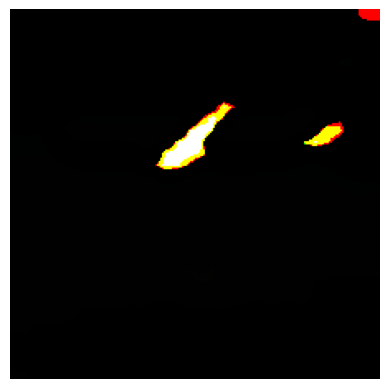

In [100]:
import matplotlib.pyplot as plt

ucc_range = (1,4)
bag_size = 25
batch_size = 16
class_generator = "combination"
instance_generator = "even"

chosen_classes = choose_classes(y_train, ucc_range, generator=class_generator)
list_limit = len(chosen_classes)
print("chosen classes: ", chosen_classes)

bag, ucc = load_bag(grouped_indices_test, train_dataset, chosen_classes[0], bag_size)
print(bag.shape, ucc.shape)
print(ucc.item())
# images, labels = next(iter(bag))
# print(images.shape)
# print(labels)

plt.imshow(bag[0].type(torch.uint8).permute(2, 1, 0))
plt.axis('off')

In [239]:
import torch.nn as nn

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride = 1, residual_function = None):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Sequential(
                        nn.Conv2d(in_channels, out_channels, kernel_size = 3, stride = stride, padding = 1),
                        nn.BatchNorm2d(out_channels),
                        nn.ReLU())
        self.conv2 = nn.Sequential(
                        nn.Conv2d(out_channels, out_channels, kernel_size = 3, stride = 1, padding = 1),
                        nn.BatchNorm2d(out_channels))
        self.residual_function = residual_function
        self.relu = nn.ReLU()
        self.out_channels = out_channels


    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.conv2(out)

        if self.residual_function:
            residual = self.residual_function(x)

        out += residual
        out = self.relu(out)

        return out

import torch.nn as nn

class Encoder(nn.Module):
    def __init__(self, block, layers, bottleneck_size = 10):
        super(Encoder, self).__init__()
        self.in_channels = 16
        self.conv1 = nn.Sequential(
                        nn.Conv2d(3, 16, kernel_size = 7, stride = 2, padding = 3),
                        nn.BatchNorm2d(16),
                        nn.ReLU())
        self.maxpool = nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)
        self.layer0 = self._build_residual_layers(block, 16, layers[0], stride = 1)
        self.layer1 = self._build_residual_layers(block, 32, layers[1], stride = 2)
        self.layer2 = self._build_residual_layers(block, 64, layers[2], stride = 2)
        self.layer3 = self._build_residual_layers(block, 128, layers[3], stride = 2)
        self.avgpool = nn.AvgPool2d(7, stride=1)
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(7*7*128, bottleneck_size)
        self.bn = nn.BatchNorm1d(bottleneck_size, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.sigmoid = nn.Sigmoid()

    def _build_residual_layers(self, block, out_channels, num_blocks, stride=1):
                
        layers = []

        # downsample the first block of each residual layer except for the first residual layer
        if stride == 1:
            layers.append(block(self.in_channels, out_channels, 1, None))          
        else:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels, kernel_size=1, stride=stride),
                nn.BatchNorm2d(out_channels),
            )
            layers.append(block(self.in_channels, out_channels, stride, downsample))    
        
        self.in_channels = out_channels

        # the rest of the blocks in the residual layer don't downsample
        for i in range(1, num_blocks):
            layers.append(block(self.in_channels, out_channels))

        return nn.Sequential(*layers)


    def forward(self, x):
        x = self.conv1(x)
        x = self.maxpool(x)

        x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)

        x = self.flatten(x)
        # x = self.avgpool(x)
        # x = x.view(x.size(0), -1)
        x = self.fc(x)
        x = self.bn(x)

        return x

class ReverseResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride = 1, residual_function = None):
        super(ReverseResidualBlock, self).__init__()
        output_padding = 0 if stride == 1 else 1
        self.conv1 = nn.Sequential(
                        nn.ConvTranspose2d(in_channels, out_channels, kernel_size = 3, stride = stride, padding = 1, output_padding=output_padding),
                        nn.BatchNorm2d(out_channels),
                        nn.ReLU())
        self.conv2 = nn.Sequential(
                        nn.ConvTranspose2d(out_channels, out_channels, kernel_size = 3, stride = 1, padding = 1),
                        nn.BatchNorm2d(out_channels))
        self.residual_function = residual_function
        self.relu = nn.ReLU()
        self.out_channels = out_channels


    def forward(self, x):

        residual = x

        out = self.conv1(x)
        out = self.conv2(out)
        
        if self.residual_function:
            residual = self.residual_function(x)   

        out += residual
        out = self.relu(out)

        return out
    
class Decoder(nn.Module):
    def __init__(self, block, layers, bottleneck_size = 10):
        super(Decoder, self).__init__()
        self.in_channels = 128
        self.fc = nn.Linear(bottleneck_size, 7*7*128)
        # self.avgpool = nn.AvgPool2d(7, stride=1)

        self.layer0 = self._build_residual_layers(block, 64, layers[0], stride = 2)
        self.layer1 = self._build_residual_layers(block, 32, layers[1], stride = 2)
        self.layer2 = self._build_residual_layers(block, 16, layers[2], stride = 2)
        self.layer3 = self._build_residual_layers(block, 16, layers[3], stride = 1)

        # upsampling is computationally cheaper
        self.upsample = nn.Upsample(scale_factor=2, mode='nearest')
        self.conv1 = nn.Sequential(
                        nn.ConvTranspose2d(16, 3, kernel_size=6, stride=4, padding=1),
                        nn.BatchNorm2d(3),
                        nn.Sigmoid())

    def _build_residual_layers(self, block, out_channels, num_blocks, stride=1):
                
        layers = []

        # upsample the first block of each residual layer except for the last residual layer
        if stride == 1:
            layers.append(block(self.in_channels, out_channels, 1, None))          
        else:
            upsample = nn.Sequential(
                nn.ConvTranspose2d(self.in_channels, out_channels, kernel_size=1, stride=stride, output_padding=1),
                nn.BatchNorm2d(out_channels),
            )
            layers.append(block(self.in_channels, out_channels, stride, upsample))    
            # layers.append(nn.Upsample(scale_factor=2, mode='nearest'))
        
        self.in_channels = out_channels

        # the rest of the blocks in the residual layer don't upsample
        for i in range(1, num_blocks):
            layers.append(block(self.in_channels, out_channels))

        return nn.Sequential(*layers)

    def forward(self, x):

        x = self.fc(x)
        x = x.view(x.size(0), 128, 7, 7)
        
        x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        
        x = self.conv1(x)

        return x

class Autoencoder(nn.Module):
    def __init__(self, encoder, bottleneck_size):
        super(Autoencoder, self).__init__()
        self.encoder = encoder
        self.decoder = Decoder(ReverseResidualBlock, [1, 1, 1, 1], bottleneck_size)

    def forward(self, x):

        x = self.encoder(x)
        x = self.decoder(x)
                
        return x
    
class Classification(nn.Module):
    def __init__(self):
        super(Classification, self).__init__()
        
        self.num_features = 16
        self.num_bins = 20
        self.sigma = 0.05
        self.bag_size = 25
        self.num_classes = 10

        self.encoder = Encoder(ResidualBlock, [3, 4, 6, 3], self.num_features)
        # self.encoder = torch.hub.load('pytorch/vision:v0.10.0', 'mobilenet_v2', pretrained=True)
        # self.encoder.classifier[1] = torch.nn.Sequential(
        #     torch.nn.Linear(self.encoder.last_channel, self.num_features),
        #     torch.nn.BatchNorm1d(self.num_features, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
        # )
        self.autoencoder = Autoencoder(self.encoder, self.num_features)
        self.fc1 = nn.Linear(self.num_bins * self.num_features, 96)
        self.fc2 = nn.Linear(96, 48)
        self.out = nn.Linear(96, self.num_classes)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=0)

    def gaussian_kernel(self, samples, data, alpha, beta):

        diff = (samples - data) ** 2
        result = alpha * torch.exp(beta * diff)

        return result

    def normalise(self, kde):

        total = 1e-10 + kde.sum(dim=1).view(-1, 1)
        normalised = kde / total.repeat(1, kde.shape[1])
        
        return normalised


    def kde(self, data):

        # (batch_size, num_features, 1)
        data = data.unsqueeze(2)
        # (1, 1, num_nodes)
        samples = torch.linspace(0, 1, steps=self.num_bins).unsqueeze(0).unsqueeze(0).to(device)
        alpha = 1 / np.sqrt(2 * np.pi * self.sigma**2)
        beta = -1 / (2 * self.sigma**2)

        result = self.gaussian_kernel(samples, data, alpha, beta)
        kde = torch.sum(result, dim=0)
        kde_normalised = self.normalise(kde)

        bag_kde = kde_normalised.view(-1)
    
        return bag_kde


    def forward(self, bag, label=None):

        features = self.encoder(bag)
        reconstructions = self.autoencoder(bag)

        if label is not None:
            
            kde = self.kde(features)
            # print("kde: ", kde)
            x = self.relu(self.fc1(kde))
            # print("first: ", x)
            # x = self.relu(self.fc2(x))
            # print("second", x)
            x = self.softmax(self.out(x))

            return x, reconstructions
        
        return features, reconstructions
                
num_epochs = 2000
learning_rate = 0.001
bag_size = 25

model = Classification()
model.to(device)

print(model)

ae_criterion = nn.MSELoss()
ucc_criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

Classification(
  (encoder): Encoder(
    (conv1): Sequential(
      (0): Conv2d(3, 16, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer0): Sequential(
      (0): ResidualBlock(
        (conv1): Sequential(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU()
        )
        (conv2): Sequential(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (relu): ReLU()
      )
      (1): ResidualBlock(
        (conv1): Sequential(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), p

In [98]:
import torch.nn.functional as F
import gc

def eval(grouped_indices, dataset, labels):
    model.eval()
    val_loss_list = []
    acc = 0
    with torch.no_grad():
        
        for i in range(32):

            chosen_classes = choose_classes(labels, ucc_range, class_generator)
            list_limit = len(chosen_classes)
            idx = 0

            if (i !=0 and i % list_limit == 0):
                chosen_classes = choose_classes(labels, ucc_range, class_generator)
                list_limit += len(chosen_classes)
                idx = 0
            
            bag, ucc = load_bag(grouped_indices, dataset, chosen_classes[idx], bag_size, batch_size)
            bag, ucc = bag.to(device), ucc.to(device)
            idx = idx + 1
            
            ucc_logits, _ = model(bag, ucc)
            ucc_val_loss = F.cross_entropy(ucc_logits.unsqueeze(0), ucc)

            prediction = torch.max(ucc_logits.unsqueeze(0), dim=1).indices
            acc += (prediction == ucc).item()
            
            val_loss_list.append(ucc_val_loss.item())

            del bag, ucc, prediction
            torch.cuda.empty_cache()
            gc.collect()

    return np.mean(val_loss_list), acc/32

In [95]:
from datetime import datetime
import pickle

def save_logs(history):
    now = datetime.now()
    filename = "logs/history_" + now.strftime("%H_%M_%S") + ".pkl"
    f = open(filename,"wb")
    pickle.dump(history,f)
    f.close()
    return filename

def load_logs(filename):
  file = open(filename,'rb')
  history = pickle.load(file)
  file.close()
  return history

In [ ]:
import gc
import time

def train(logs={}):
    model.train()

    # reload on failure
    if not(logs):
        logs["loss"] = []

        logs["val_loss"] = []        
        logs["val_accuracy"] = []
    else:
        min_loss = min(logs["val_loss"])
        print("continue from past state, min_loss: ", min_loss)

    chosen_classes = choose_classes(y_train, ucc_range, class_generator)
    list_limit = len(chosen_classes)
    idx = 0
    best_val_acc = 0.

    for epoch in range(num_epochs):

        start = time.time()

        # randomise the chosen classes
        if (epoch !=0 and epoch % list_limit == 0):
            chosen_classes = choose_classes(y_train, ucc_range, class_generator)
            list_limit += len(chosen_classes)
            idx = 0
        
        bag, ucc = load_bag(grouped_indices_train, train_dataset, chosen_classes[idx], bag_size, batch_size)
        bag, ucc = bag.to(device), ucc.to(device)
        idx = idx + 1

        predictions, reconstructions = model(bag, ucc)
        # print("predictions: ", predictions)
        
        ae_loss = ae_criterion(reconstructions, bag)
        ucc_loss = ucc_criterion(predictions.unsqueeze(0), ucc)  

        # print("ae_loss: ", ae_loss.item())
        # print("ucc_loss: ", ucc_loss.item())

        alpha = 0.5

        loss = ae_loss * (1 - alpha) + ucc_loss * (alpha)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if epoch % 10 == 0:
            val_loss, val_acc = eval(grouped_indices_val, val_dataset, y_val)
            logs["val_accuracy"].append(val_acc)
            logs["val_loss"].append(val_loss.item())
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                
                torch.save(model.state_dict(), "models/model.pth")

            print ('Epoch [{}/{}], time: {:.0f}, Loss: {:.4f} | Val Loss: {:.4f}, Val Acc: {:.4f}'
                        .format(epoch+1, num_epochs, time.time() - start, loss.item(), val_loss, val_acc))
            
        logs["loss"].append(loss.item())

        save_logs(logs)

        del bag, predictions, reconstructions
        torch.cuda.empty_cache()
        gc.collect()

    return logs

history = train()
        

torch.Size([25, 3, 224, 224])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


index:  23
features:  torch.Size([25, 16])
reconstructions:  torch.Size([25, 3, 224, 224])
distributions:  torch.Size([16, 20])


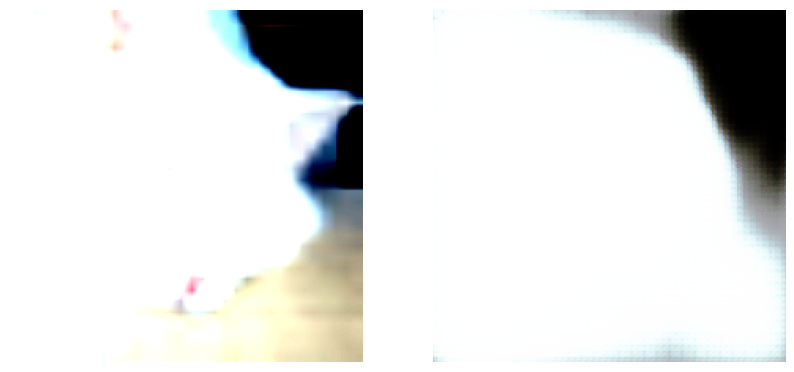

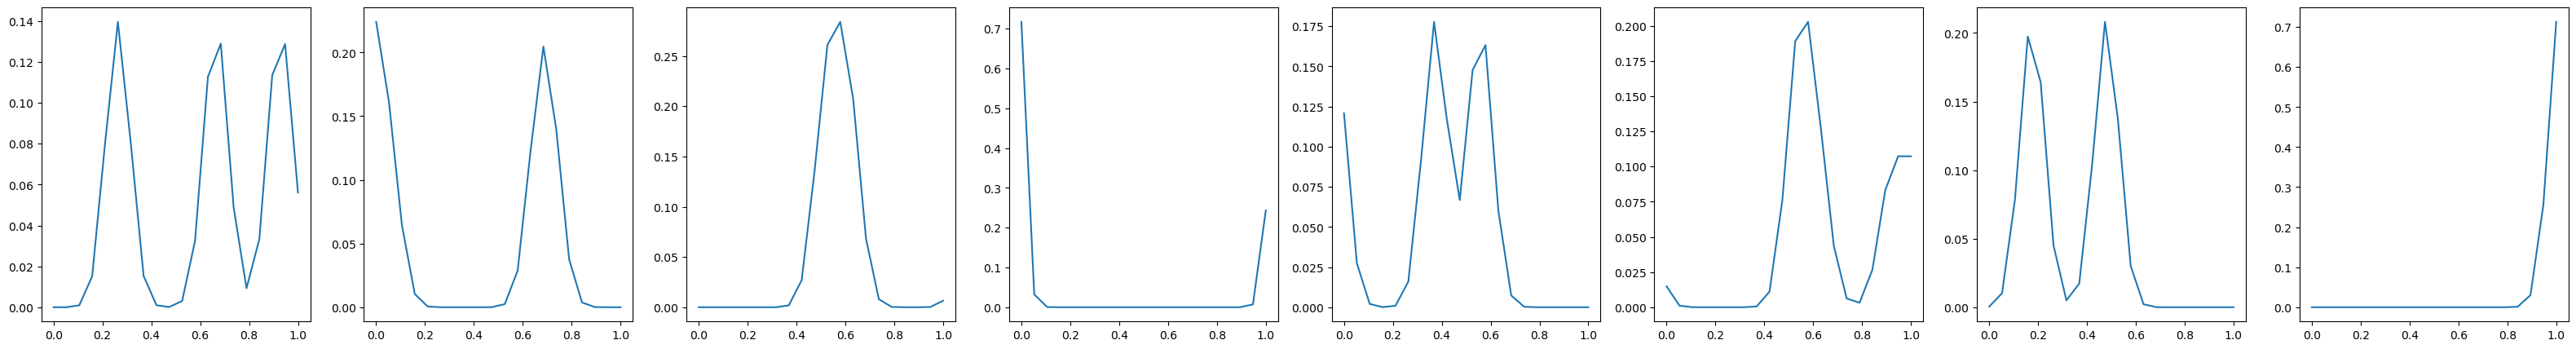

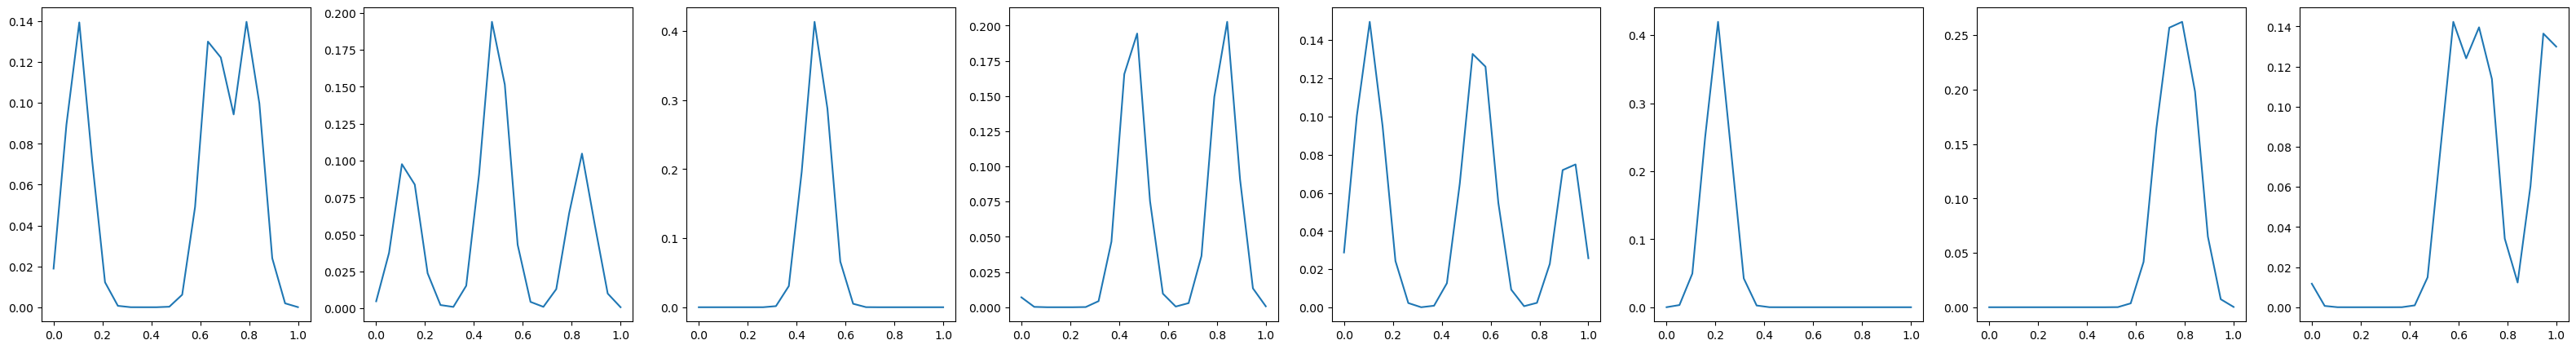

In [242]:
import matplotlib.pyplot as plt
import random

with torch.no_grad():
    
    test_image, test_label = load_bag(grouped_indices_test, test_dataset, (0,1,2,3), 25)
    images = test_image.to(device)
    print(images.shape)

    idx = random.randint(0, len(test_image) - 1)
    features, reconstructions = model(images)
    distributions = model.kde(features).reshape(16, 20)

    print("index: ", idx)
    print("features: ", features.shape)
    print("reconstructions: ", reconstructions.shape)
    print("distributions: ", distributions.shape)
    # outputs = outputs.cpu()
    # result = model(test_image[idx].squeeze(0).to(device))
    # print(test_image[idx].permute(2, 1, 0))
    # print(outputs[idx].permute(2, 1, 0))
    
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    axs[0].imshow(test_image[idx].permute(2, 1, 0))
    axs[0].axis('off')
    axs[1].imshow(reconstructions[idx].cpu().permute(2, 1, 0))
    axs[1].axis('off')

    num_features = 16
    half = num_features // 2
    fig, axs2 = plt.subplots(1, half, figsize=(40, 5))
    x = torch.linspace(0, 1, steps=20)
    for i in range(half):
        axs2[i].plot(x, distributions[i].cpu().numpy())
    fig, axs3 = plt.subplots(1, half, figsize=(40, 5))
    for i, dist in enumerate(range(half, num_features)):
        axs3[i].plot(x, distributions[dist].cpu().numpy())

    plt.show()

    del test_image, test_label, features, reconstructions, distributions
    torch.cuda.empty_cache()

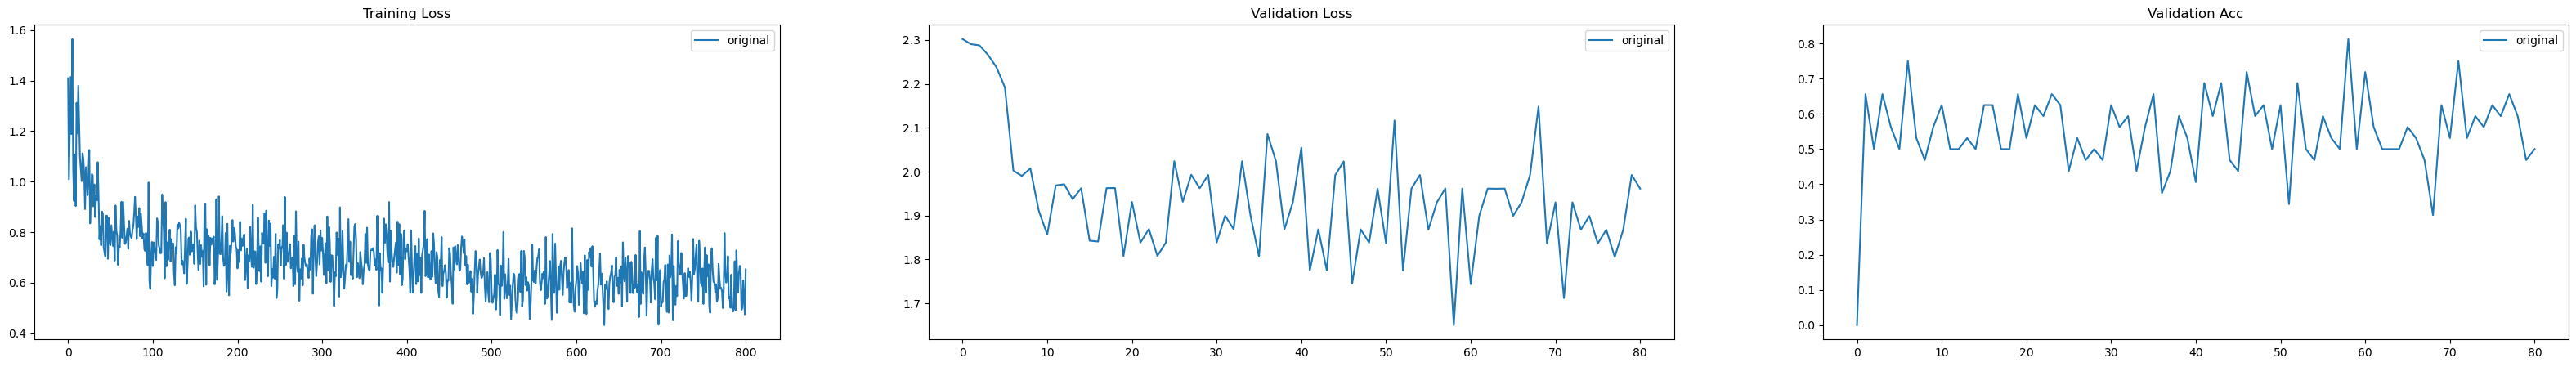

test_loss:  1.836365282535553
test_acc:  0.625


In [246]:

history = load_logs("logs/history_18_57_01.pkl")

with torch.no_grad():
    _, vaxs = plt.subplots(1, 3, figsize=(40, 5)) 
    vaxs[0].plot(history["loss"], label="original")
    vaxs[0].set_title("Training Loss")
    vaxs[0].legend()

    vaxs[1].plot(history["val_loss"], label="original")
    vaxs[1].set_title("Validation Loss")
    vaxs[1].legend()

    vaxs[2].plot(history["val_accuracy"], label="original")
    vaxs[2].set_title("Validation Acc")
    vaxs[2].legend()

    plt.show()

    test_loss, test_acc = eval(grouped_indices_test, test_dataset, y_test)
    print("test_loss: ", test_loss)
    print("test_acc: ", test_acc)

    

In [248]:
def js_divergence(p,q):
	m = 0.5*(p+q)
	log_p_over_m = np.log2(p/m)
	log_q_over_m = np.log2(q/m)

	return 0.5*np.sum(p*log_p_over_m) + 0.5*np.sum(q*log_q_over_m)

with torch.no_grad():
    features = []
    for sample, _ in test_dataset:
        feature = model.encoder(sample.unsqueeze(0))
        features.append(feature.cpu())

    # print("features: ", features[0].shape)    
    features = torch.cat(features, dim=0)

    feature_dist_by_class = {}
    
    for label in torch.unique(y_test):
         feature_dist_by_class[label.item()] = []
    
    # print("feature_dist_by_class: ", feature_dist_by_class)


    for feature, label in zip(features, y_test):
        feature_dist_by_class[label.item()].append(feature)

    # print("feature_dist_by_class: ", feature_dist_by_class)

    for label in torch.unique(y_test):
        if len(feature_dist_by_class[label.item()]) > 1:
            feature_dist_by_class[label.item()] = model.kde(torch.stack(feature_dist_by_class[label.item()])) 
        else:
            feature_dist_by_class[label.item()] = model.kde(feature_dist_by_class[label.item()])

    # print("features: ", feature_dist_by_class)
    feature_distribution_arr = np.zeros(
        (10, feature_dist_by_class[0].shape[0])
    )

    for c in feature_dist_by_class:
        feature_distribution_arr[c] = feature_dist_by_class[c].cpu().numpy()

    js_divergence_arr = np.zeros((10,10))
    feature_distribution_norm = feature_distribution_arr / 16
    for i in range(10):
        p = np.clip(feature_distribution_norm[i,:], 1e-12, 1)
        
        for k in range(i, 10):
            q = np.clip(feature_distribution_norm[k,:], 1e-12, 1)
            js_divergence_arr[i,k] = js_divergence(p,q)
            js_divergence_arr[k,i] = js_divergence_arr[i,k]
    print('JS divergence: min={:.2f} - max={:.3f} - mean={:.3f} - std={:.3f}'.format(
        np.amin(js_divergence_arr[js_divergence_arr>0]),np.amax(js_divergence_arr),np.mean(js_divergence_arr),np.std(js_divergence_arr)))


JS divergence: min=0.01 - max=0.029 - mean=0.019 - std=0.007


In [249]:
from time import time
from sklearn import metrics
from sklearn.cluster import KMeans, SpectralClustering
from scipy.optimize import linear_sum_assignment


def eval_clustering(estimator=None, name=None, data=None, labels=None):
	t0 = time()
	estimator.fit(data)
	homogeneity_score = metrics.homogeneity_score(labels, estimator.labels_)
	completeness_score = metrics.completeness_score(labels, estimator.labels_)
	v_measure_score = metrics.v_measure_score(labels, estimator.labels_)
	adjusted_rand_score = metrics.adjusted_rand_score(labels, estimator.labels_)
	adjusted_mutual_info_score = metrics.adjusted_mutual_info_score(labels,  estimator.labels_)

	clustering_scores = np.array([homogeneity_score, completeness_score, v_measure_score, adjusted_rand_score, adjusted_mutual_info_score]).reshape((1,-1))
	return clustering_scores

num_clusters = 10
estimator = SpectralClustering(n_clusters=num_clusters, eigen_solver='arpack', affinity="nearest_neighbors")
spectral_clustering_scores = eval_clustering(estimator=estimator, name='all: spectral-nn', data=features, labels=y_test.squeeze(1))

estimator = KMeans(n_clusters=num_clusters, init='k-means++', n_init=10)
kmeans_clustering_scores = eval_clustering(estimator=estimator, name='all: kmeans++', data=features, labels=y_test.squeeze(1))

nn_estimator = SpectralClustering(n_clusters=num_clusters, eigen_solver='arpack', affinity="nearest_neighbors")
kmeans_estimator = KMeans(n_clusters=num_clusters, init='k-means++', n_init=10)


def predict_cluster_labels(estimator=None, data=None):
	estimator.fit(data)
	predicted_clustering_labels = estimator.labels_

	return predicted_clustering_labels

nn_predicted_labels = predict_cluster_labels(estimator=nn_estimator, data=features)
kmeans_predicted_labels = predict_cluster_labels(estimator=kmeans_estimator, data=features)

def compute_clustering_accuracy(truth_labels_arr, predicted_labels_arr):	
    cost_matrix = np.zeros((10,10))
    num_samples = np.zeros(10)
    for truth_val in range(10):
        temp_sample_indices = np.where(truth_labels_arr == truth_val)[0]
        num_samples[truth_val] = temp_sample_indices.shape[0]

        temp_predicted_labels = predicted_labels_arr[temp_sample_indices]

        for predicted_val in range(10):

            temp_matching_pairs = np.where(temp_predicted_labels == predicted_val)[0]

            cost_matrix[truth_val,predicted_val] = 1- (temp_matching_pairs.shape[0]/temp_sample_indices.shape[0])

    row_ind, col_ind = linear_sum_assignment(cost_matrix)

    cost = cost_matrix[row_ind,col_ind]

    clustering_acc = ((1-cost)*num_samples).sum() / num_samples.sum()
    return clustering_acc

nn_cluster_acc = compute_clustering_accuracy(
    y_test.squeeze(1), nn_predicted_labels)
kmeans_cluster_acc = compute_clustering_accuracy(
    y_test.squeeze(1), kmeans_predicted_labels)
print('nn_cluster_acc: {:.3f} - kmeans_cluster_acc: {:.3f}'.format(nn_cluster_acc, kmeans_cluster_acc))

nn_cluster_acc: 0.188 - kmeans_cluster_acc: 0.217
